# NLP Basic Assignment
## NLP 맛보기 - spam.csv를 가지고 유의미한 해석을 도출해주세요!

In [65]:
!pip install glove_python_binary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [66]:
# 필요한 모듈 불러오기 

import gensim
from gensim.models import Word2Vec, FastText
import glove
from glove import Corpus, Glove
import scipy.stats as st

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import re
import nltk
nltk.download('punkt')
from nltk import word_tokenize

from collections import Counter
from sklearn.manifold import TSNE
import matplotlib.font_manager as fm
import matplotlib as mpl
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Load Data
- 보시면 아시다시피 spam.csv는 라벨이 있는 데이터입니다. 물론 7주차 주제가 텍스트 기초인만큼 텍스트만 활용하셔도 되고, 라벨까지 활용하셔서 모델을 돌려보셔도 좋습니다 :)

In [67]:
spam = pd.read_csv('spam.csv')
spam

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [68]:
spam.iloc[5]['v2']

"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, å£1.50 to rcv"

In [69]:
spam.isnull().sum() # 결측치 확인

v1    0
v2    0
dtype: int64

In [70]:
spam.duplicated(['v2']).sum() # 중복값 확인

403

In [71]:
spam.drop_duplicates(['v2'], inplace=True) # 중복값 제거

In [72]:
spam.reset_index(drop=True, inplace=True) # 인덱스 재배치
spam

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5164,spam,This is the 2nd time we have tried 2 contact u...
5165,ham,Will Ì_ b going to esplanade fr home?
5166,ham,"Pity, * was in mood for that. So...any other s..."
5167,ham,The guy did some bitching but I acted like i'd...


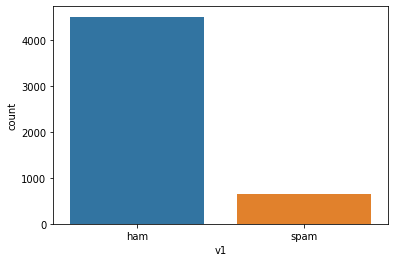

In [73]:
sns.countplot(spam["v1"])

In [74]:
# ham -> 0, spam -> 1로 바꾸기
spam.v1 = spam.v1.replace(['ham','spam'],[0,1])
spam

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5164,1,This is the 2nd time we have tried 2 contact u...
5165,0,Will Ì_ b going to esplanade fr home?
5166,0,"Pity, * was in mood for that. So...any other s..."
5167,0,The guy did some bitching but I acted like i'd...


In [75]:
import re

# 영어 문자만 남기고 대문자는 소문자로 변환

def cleanText(data):
  text = re.sub('[^a-zA-Z]', ' ', data).lower()
  return text

spam.v2 = spam.v2.apply(cleanText)
spam

,v1,v2
0,0,go until jurong point crazy available only ...
1,0,ok lar joking wif u oni
2,1,free entry in a wkly comp to win fa cup fina...
3,0,u dun say so early hor u c already then say
4,0,nah i don t think he goes to usf he lives aro...
...,...,...
5164,1,this is the nd time we have tried contact u...
5165,0,will b going to esplanade fr home
5166,0,pity was in mood for that so any other s...
5167,0,the guy did some bitching but i acted like i d...


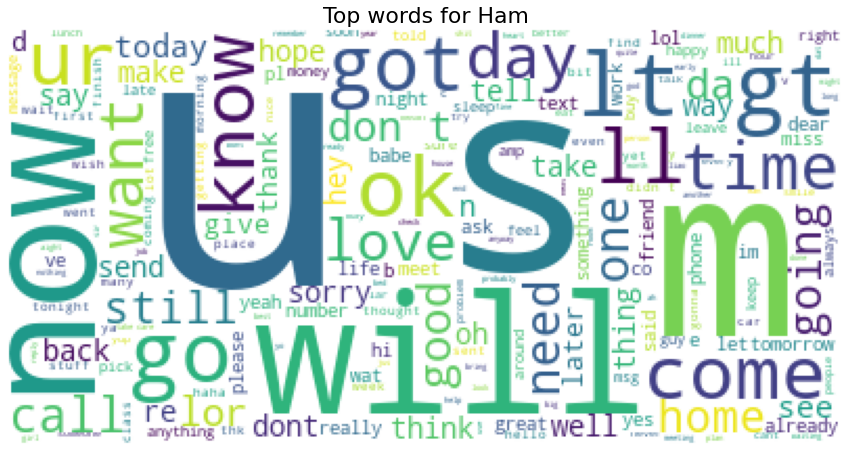

In [76]:
wc = WordCloud(background_color='white', max_words=200)

wc.generate(' '.join(text for text in spam[spam['v1']==0].v2))
plt.figure(figsize=(15, 10))
plt.title('Top words for Ham', fontdict={'size':22})
plt.imshow(wc)
plt.axis('off')
plt.show()

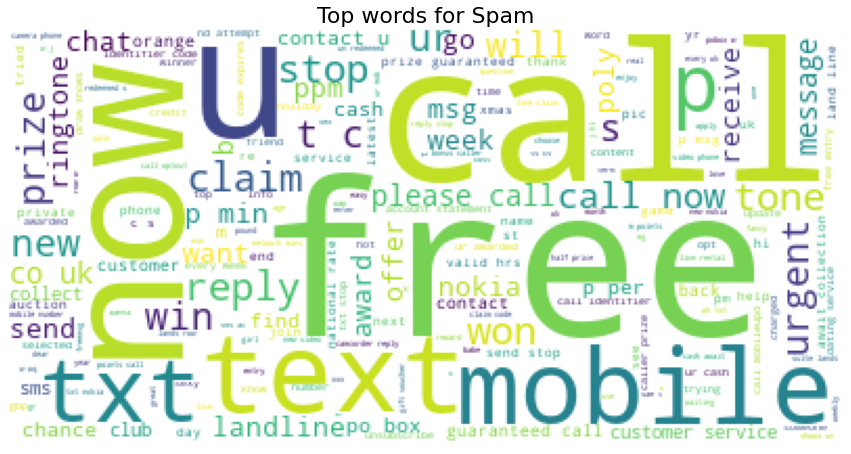

In [77]:
wc = WordCloud(background_color='white', max_words=200)

wc.generate(' '.join(text for text in spam[spam['v1']==1].v2))
plt.figure(figsize=(15, 10))
plt.title('Top words for Spam', fontdict={'size':22})
plt.imshow(wc)
plt.axis('off')
plt.show()

스팸이 아닌 메일에 비해 스팸 메일에서 free, call, mobile, text, prize, urgent, reply 등의 단어가 많이 보인다

## Tokenizing


In [78]:
# 예시 코드 코드
nltk.download('punkt')
word_tokenize(spam.iloc[5]['v2'])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['freemsg',
 'hey',
 'there',
 'darling',
 'it',
 's',
 'been',
 'week',
 's',
 'now',
 'and',
 'no',
 'word',
 'back',
 'i',
 'd',
 'like',
 'some',
 'fun',
 'you',
 'up',
 'for',
 'it',
 'still',
 'tb',
 'ok',
 'xxx',
 'std',
 'chgs',
 'to',
 'send',
 'to',
 'rcv']

In [79]:
# 영어 불용어 리스트
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
print(stop_words)

{'by', 'on', 'which', "didn't", 'having', 'its', 'did', 'it', 'herself', 'about', 've', 'or', 'that', 'myself', 'ours', 'isn', 'am', 'this', 'between', "wouldn't", 'in', 'most', 'he', 'few', 'o', 'into', "mightn't", "wasn't", 'more', 'again', 'had', 'if', 'does', 'have', 'an', 'hadn', 'theirs', 'were', 'my', 'hers', 'at', 'each', 'doing', 'hasn', 'how', "mustn't", 'haven', 't', "shan't", 'yourself', 'be', 'with', "it's", 'over', "hasn't", 'all', 'whom', 'll', 'yours', 'being', 'to', 'some', 'own', 'her', "haven't", 'should', 'doesn', 'm', 'you', 'i', 'because', 'too', "she's", 'as', 'his', 'are', 'until', "you've", 'wasn', 'other', "you'd", 'before', 'there', 'up', 'where', 'above', 'ma', 'she', 'just', "should've", "that'll", 'aren', "couldn't", 'themselves', 'under', 'those', 'himself', 'couldn', 'further', 'once', 'out', "won't", 's', 'weren', 'was', 're', 'off', 'these', 'your', 'is', 'has', 'same', 'so', 'wouldn', "weren't", 'me', 'then', 'through', 'but', "aren't", 'down', 'them'

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [80]:
result = []
for i in spam.v2:
  word_tokens = word_tokenize(i) # 행마다 word 토큰화
  words = [w for w in word_tokens if w not in stop_words] # 불용어 제거
  result.append(words) 
  
print(result)

[['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'got', 'amore', 'wat'], ['ok', 'lar', 'joking', 'wif', 'u', 'oni'], ['free', 'entry', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 'c', 'apply'], ['u', 'dun', 'say', 'early', 'hor', 'u', 'c', 'already', 'say'], ['nah', 'think', 'goes', 'usf', 'lives', 'around', 'though'], ['freemsg', 'hey', 'darling', 'week', 'word', 'back', 'like', 'fun', 'still', 'tb', 'ok', 'xxx', 'std', 'chgs', 'send', 'rcv'], ['even', 'brother', 'like', 'speak', 'treat', 'like', 'aids', 'patent'], ['per', 'request', 'melle', 'melle', 'oru', 'minnaminunginte', 'nurungu', 'vettam', 'set', 'callertune', 'callers', 'press', 'copy', 'friends', 'callertune'], ['winner', 'valued', 'network', 'customer', 'selected', 'receivea', 'prize', 'reward', 'claim', 'call', 'claim', 'code', 'kl', 'valid', 'hours'], ['mobile', 'months', '

In [81]:
spam_c = spam.copy()
spam_c.v2 = result
spam_c

,v1,v2
0,0,"[go, jurong, point, crazy, available, bugis, n..."
1,0,"[ok, lar, joking, wif, u, oni]"
2,1,"[free, entry, wkly, comp, win, fa, cup, final,..."
3,0,"[u, dun, say, early, hor, u, c, already, say]"
4,0,"[nah, think, goes, usf, lives, around, though]"
...,...,...
5164,1,"[nd, time, tried, contact, u, u, pound, prize,..."
5165,0,"[b, going, esplanade, fr, home]"
5166,0,"[pity, mood, suggestions]"
5167,0,"[guy, bitching, acted, like, interested, buyin..."


## Embedding

- 수업에서 다룬 임베딩 방법에는 One-hot encoding, CBOW, Skip-gram, GloVe, FastText가 있었습니다. 다양한 시도와 '비교' 결과를 함께 적어주세요! 파라미터를 조정해가는 과정도 해석에 도움이 될 수 있겠죠 :)


워드 임베딩은 "**무슨 정보를 이용해 단어를 표현하느냐**"에 따라 다양한 종류로 나누어진다. 

|종류|정보|설명|
|-|-|-|
|Word2Vec|주변 단어|한 단어의 주변 단어를 통해 그 단어의 의미를 파악 : context=>target인 CBOW 모델 & target=>context인 skip-gram 모델|
|FastText|주변 단어 + n-gram|Word2Vec과 유사한 방식으로 학습하나, 단어를 n-gram으로 나누어 학습하여 subword information을 고려|
| GloVe|주변 단어 + 전체 코퍼스의 분포|한 단어의 의미를 표현하는 데 주변 단어만 고려한다는 한계를 극복하기 위해 전체 코퍼스의 통계 정보를 고려|

### Word2Vec

#### Skip-gram

In [82]:
# ham에 대해 학습
# word2vec 모델 선언 
# iter: 학습수, min_count: 최소 단어 반복, size=임베딩벡터 차원수, window=앞뒤 단어 개수, sg: skipgram
model = Word2Vec(spam_c[spam_c.v1 == 0]['v2'], min_count=5, size=100, window=2, iter=200, sg=1)

In [83]:
model.save('w2v_model_ham')

In [84]:
w2v_model_ham = Word2Vec.load('w2v_model_ham')

In [85]:
w2v_model_ham.similarity('love', 'good') # love와 good의 유사도

0.22912991

In [86]:
w2v_model_ham.most_similar(positive=["love"], topn=10) # love와 가장 비슷한 top 10 token

[('kiss', 0.477167546749115),
 ('comes', 0.44626736640930176),
 ('belly', 0.4176730215549469),
 ('geeee', 0.41396480798721313),
 ('teasing', 0.41335296630859375),
 ('loverboy', 0.4106981158256531),
 ('boytoy', 0.4059893488883972),
 ('xxx', 0.3933880031108856),
 ('buns', 0.39271628856658936),
 ('merry', 0.3830873668193817)]

In [87]:
w2v_model_ham.most_similar(positive=['love'], negative= ['sorry'], topn=10)

[('kiss', 0.35319381952285767),
 ('comes', 0.34112808108329773),
 ('loved', 0.29006800055503845),
 ('belly', 0.28596267104148865),
 ('boytoy', 0.2745101749897003),
 ('luck', 0.23519766330718994),
 ('loads', 0.22438466548919678),
 ('hurry', 0.22357095777988434),
 ('loves', 0.21889817714691162),
 ('ones', 0.20714181661605835)]

In [88]:
w2v_model_ham.wv.doesnt_match('love kiss cute lar'.split()) # 가장 무관한 단어

'lar'

In [89]:
# spam에 대해 학습
model = Word2Vec(spam_c[spam_c.v1 == 1]['v2'], min_count=5, size=100, window=2, iter=200, sg=1)

In [90]:
model.save('w2v_model_spam')

In [91]:
w2v_model_spam = Word2Vec.load('w2v_model_spam')

In [92]:
w2v_model_spam.similarity('call', 'urgent') # call와 urgent의 유사도

0.25264615

In [93]:
w2v_model_spam.most_similar(positive=["call"], topn=10) # call과 가장 비슷한 top 10 token

[('quoting', 0.4060971438884735),
 ('expires', 0.3959285616874695),
 ('rental', 0.37493255734443665),
 ('claim', 0.36068814992904663),
 ('ls', 0.34701400995254517),
 ('un', 0.3441751003265381),
 ('identifier', 0.34240925312042236),
 ('j', 0.3325420320034027),
 ('del', 0.32894235849380493),
 ('still', 0.3286535143852234)]

In [94]:
w2v_model_spam.most_similar(positive=['call'], negative= ['text'], topn=10)

[('landline', 0.2675545811653137),
 ('claim', 0.24651172757148743),
 ('j', 0.24132895469665527),
 ('ppm', 0.2227167785167694),
 ('todays', 0.2181704193353653),
 ('bt', 0.21345658600330353),
 ('tenerife', 0.21254415810108185),
 ('ls', 0.21167123317718506),
 ('quoting', 0.20078295469284058),
 ('holder', 0.18669737875461578)]

In [95]:
w2v_model_spam.wv.doesnt_match('urgent call text today'.split()) # 가장 무관한 단어

'today'

#### CBOW

In [96]:
model = Word2Vec(spam_c[spam_c.v1 == 0]['v2'], min_count=5, size=100, window=2, iter=200, sg=0)

In [97]:
model.save('w2v_model_ham_cbow')

In [98]:
w2v_model_ham_cbow = Word2Vec.load('w2v_model_ham_cbow')

In [99]:
w2v_model_ham_cbow.similarity('love', 'good')

0.3556227

In [100]:
w2v_model_ham_cbow.most_similar(positive=["love"], topn=10)

[('kiss', 0.4130311608314514),
 ('beautiful', 0.40769970417022705),
 ('lift', 0.3788611888885498),
 ('good', 0.35562270879745483),
 ('bcoz', 0.35258781909942627),
 ('teasing', 0.3507263660430908),
 ('loved', 0.3468286991119385),
 ('dreams', 0.32291167974472046),
 ('merry', 0.3205268085002899),
 ('heart', 0.303460955619812)]

In [101]:
w2v_model_ham_cbow.most_similar(positive=["love"], negative= ['sorry'], topn=10)

[('loved', 0.4138057231903076),
 ('bcoz', 0.3665946424007416),
 ('belly', 0.35847151279449463),
 ('kiss', 0.3520842492580414),
 ('christmas', 0.32176142930984497),
 ('dreams', 0.3201080560684204),
 ('boytoy', 0.31855639815330505),
 ('waking', 0.31190627813339233),
 ('teasing', 0.30903470516204834),
 ('loving', 0.3040887713432312)]

In [102]:
w2v_model_ham_cbow.wv.doesnt_match('love kiss cute lar'.split()) # 가장 무관한 단어

'lar'

In [103]:
# spam에 대해 학습
model = Word2Vec(spam_c[spam_c.v1 == 1]['v2'], min_count=5, size=100, window=2, iter=200, sg=0)

In [104]:
model.save('w2v_model_spam_cbow')

In [105]:
w2v_model_spam_cbow = Word2Vec.load('w2v_model_spam_cbow')

In [106]:
w2v_model_spam_cbow.similarity('call', 'urgent') 

0.21417955

In [107]:
w2v_model_spam_cbow.most_similar(positive=["call"], topn=10) 

[('quoting', 0.4072267711162567),
 ('bt', 0.4043140411376953),
 ('pound', 0.38038504123687744),
 ('line', 0.35203367471694946),
 ('code', 0.34858787059783936),
 ('ppm', 0.3189816474914551),
 ('landline', 0.31663966178894043),
 ('identifier', 0.3164690136909485),
 ('expires', 0.31388774514198303),
 ('del', 0.30855780839920044)]

In [108]:
w2v_model_spam_cbow.most_similar(positive=['call'], negative= ['text'], topn=10)

[('landline', 0.36558035016059875),
 ('quoting', 0.35266387462615967),
 ('complimentary', 0.32752281427383423),
 ('tenerife', 0.3129434585571289),
 ('bt', 0.3117017149925232),
 ('j', 0.3116335868835449),
 ('row', 0.2981221675872803),
 ('todays', 0.2948946952819824),
 ('voda', 0.28742384910583496),
 ('ls', 0.2873205542564392)]

In [109]:
w2v_model_spam_cbow.wv.doesnt_match('urgent call text today'.split()) # 가장 무관한 단어

'urgent'

### FastText

In [110]:
# 모델 선언, 차원수는 100
model = FastText(size=100, window=2)

In [111]:
# ham
fast_model = FastText(spam_c[spam_c.v1 == 0]['v2'], size=100, window=5, min_count=5, workers=4, sg=1)

In [112]:
fast_model.most_similar(positive=["love"], topn=10)

[('loved', 0.9992292523384094),
 ('loves', 0.9992192983627319),
 ('babe', 0.999137282371521),
 ('kiss', 0.999085545539856),
 ('think', 0.999078094959259),
 ('missing', 0.9990525245666504),
 ('hope', 0.999038577079773),
 ('lovely', 0.9990103244781494),
 ('loverboy', 0.9990038871765137),
 ('miss', 0.9989914298057556)]

In [113]:
# spam
fast_model_s = FastText(spam_c[spam_c.v1 == 1]['v2'], size=100, window=5, min_count=5, workers=4, sg=1)

In [114]:
fast_model_s.most_similar(positive=["call"], topn=10)

[('caller', 0.9998401999473572),
 ('calls', 0.9997379183769226),
 ('claim', 0.9996321201324463),
 ('calling', 0.9996234774589539),
 ('prize', 0.9996170997619629),
 ('urgent', 0.9996113181114197),
 ('bonus', 0.9995805025100708),
 ('guaranteed', 0.9995599985122681),
 ('awarded', 0.9995274543762207),
 ('number', 0.9995226263999939)]

### GloVe

In [115]:
# ham
corpus = Corpus()
corpus.fit(spam_c[spam_c.v1 == 0]['v2'],window=2)

In [116]:
# 모델 선언 
model = Glove(no_components=5, learning_rate=0.05)
model.fit(corpus.matrix, epochs=200, no_threads=4, verbose=False)

In [117]:
model.add_dictionary(corpus.dictionary) # 모델에 단어 사전 올려줌

In [118]:
model.save('gv_model_ham')
gv_model_ham = Glove.load('gv_model_ham')

In [119]:
gv_model_ham.most_similar('love')

[('along', 0.9779165731854774),
 ('middle', 0.9763853386758856),
 ('hope', 0.9694588874236798),
 ('hence', 0.961109612722393)]

In [120]:
# spam
corpus = Corpus()
corpus.fit(spam_c[spam_c.v1 == 1]['v2'],window=2)

In [121]:
model = Glove(no_components=5, learning_rate=0.05)
model.fit(corpus.matrix, epochs=200, no_threads=4, verbose=False)
model.add_dictionary(corpus.dictionary)
model.save('gv_model_spam')
gv_model_spam = Glove.load('gv_model_spam')

In [122]:
gv_model_spam.most_similar('call')

[('b', 0.9810909658126755),
 ('freephone', 0.9758072487731906),
 ('please', 0.9573893718517126),
 ('alfie', 0.9425152935921572)]

## Visualizing

In [123]:
path_nanum = "/content/malgun.ttf"
prop = fm.FontProperties(fname=path_nanum)

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False 

In [124]:
spam_words = []
for i in spam[spam.v1 == 1]['v2']:
  word_tokens = word_tokenize(i) # 행마다 word 토큰화
  words = [w for w in word_tokens if w not in stop_words] # 불용어 제거
  spam_words+=words
  
print(spam_words)

['free', 'entry', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 'c', 'apply', 'freemsg', 'hey', 'darling', 'week', 'word', 'back', 'like', 'fun', 'still', 'tb', 'ok', 'xxx', 'std', 'chgs', 'send', 'rcv', 'winner', 'valued', 'network', 'customer', 'selected', 'receivea', 'prize', 'reward', 'claim', 'call', 'claim', 'code', 'kl', 'valid', 'hours', 'mobile', 'months', 'u', 'r', 'entitled', 'update', 'latest', 'colour', 'mobiles', 'camera', 'free', 'call', 'mobile', 'update', 'co', 'free', 'six', 'chances', 'win', 'cash', 'pounds', 'txt', 'csh', 'send', 'cost', 'p', 'day', 'days', 'tsandcs', 'apply', 'reply', 'hl', 'info', 'urgent', 'week', 'free', 'membership', 'prize', 'jackpot', 'txt', 'word', 'claim', 'c', 'www', 'dbuk', 'net', 'lccltd', 'pobox', 'ldnw', 'rw', 'xxxmobilemovieclub', 'use', 'credit', 'click', 'wap', 'link', 'next', 'txt', 'message', 'click', 'http', 'wap', 'xxxmobilemovieclub', 'com',

In [125]:
# word2vec에 대한 시각화를 진행할 것으므로, model에 원하는 word2vec 모델을 올려줍니다. 
model = Word2Vec.load('w2v_model_spam')

# 가장 빈도수가 높은 100개의 단어 추출 
freq_list = Counter(spam_words).most_common(100)
vocab = [i[0] for i in freq_list if len(i[0])>1]

# 해당 단어들에 해당하는 임베딩 벡터
X = model[vocab]

# 2차원으로 축소합니다. 
tsne = TSNE(perplexity=30,n_components=2, init='pca', n_iter=3500, random_state=12)

In [126]:
def tsne_2d(title, tsne):
    # 100 => 2차원
    X_tsne = tsne.fit_transform(X[:300,:])
    df = pd.DataFrame(X_tsne, index=vocab[:300], columns=['x', 'y'])
    
    %matplotlib inline
    fig = plt.figure()
    fig.set_size_inches(20, 10)
    ax = fig.add_subplot(1, 1, 1)
    ax.scatter(df["x"], df["y"])
    for word, pos in list(df.iterrows()):
        ax.annotate(word, pos, fontsize=12, fontproperties=prop)
    plt.title(title)
    plt.show()

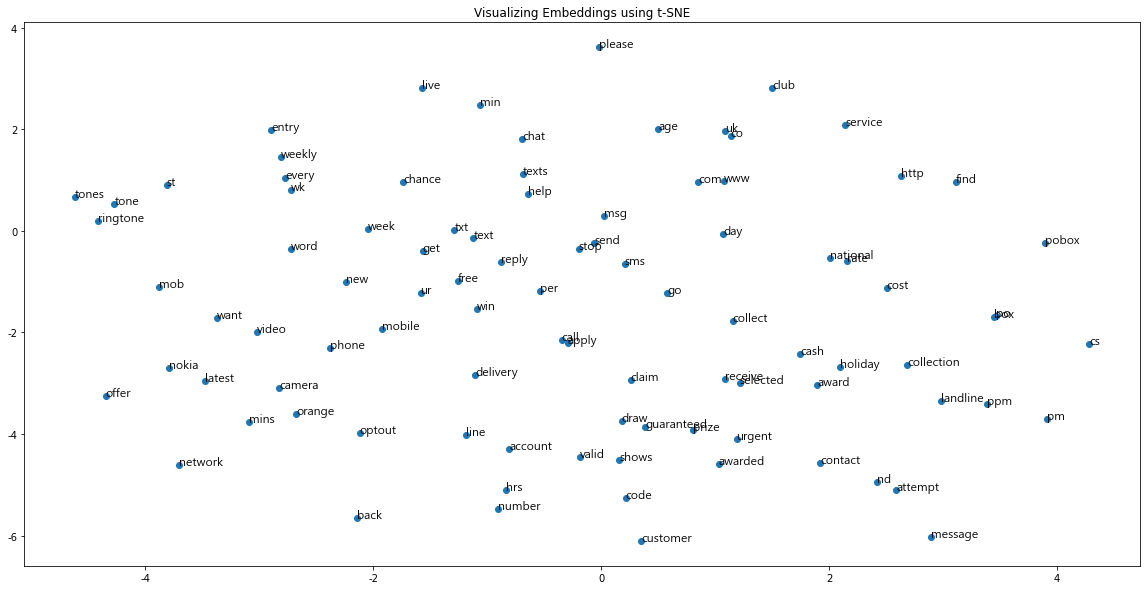

In [127]:
tsne_2d('Visualizing Embeddings using t-SNE', tsne)

## 본인이 도출해낸 해석을 적어주세요!

- 유사도, Wordcloud, 이진 분류 모델, Plot 뭐든 상관없으니 분명하고 인상적인 해석을 적어주시면 됩니다.

In [128]:
wc = WordCloud(background_color='white', max_words=100, width = 400, height = 300)

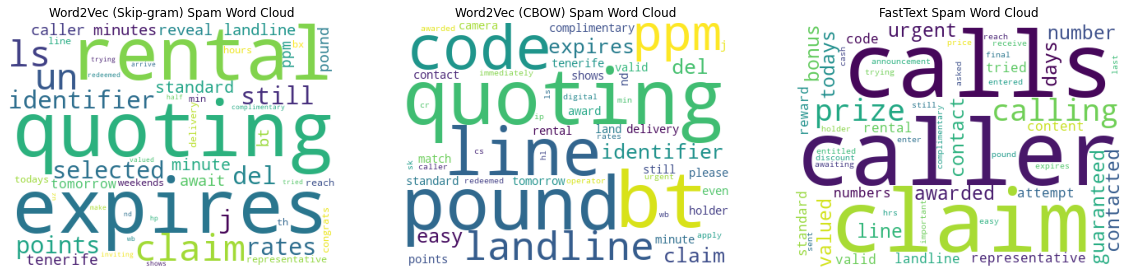

In [129]:
plt.figure(figsize=(20,10))

plt.subplot(1,3,1)
plt.title('Word2Vec (Skip-gram) Spam Word Cloud')
count_dic = dict(zip([x[0] for x in w2v_model_spam.most_similar(positive=["call"], topn=50)],
                     [x[1] for x in w2v_model_spam.most_similar(positive=["call"], topn=50)]))
cloud = wc.generate_from_frequencies(count_dic)
plt.axis('off')
plt.imshow(cloud)

plt.subplot(1,3,2)
plt.title('Word2Vec (CBOW) Spam Word Cloud')
count_dic = dict(zip([x[0] for x in w2v_model_spam_cbow.most_similar(positive=["call"], topn=50)],
                     [x[1] for x in w2v_model_spam_cbow.most_similar(positive=["call"], topn=50)]))
cloud = wc.generate_from_frequencies(count_dic)
plt.axis('off')
plt.imshow(cloud)

plt.subplot(1,3,3)
plt.title('FastText Spam Word Cloud')
count_dic = dict(zip([x[0] for x in fast_model_s.most_similar(positive=["call"], topn=50)],
                     [x[1] for x in fast_model_s.most_similar(positive=["call"], topn=50)]))
cloud = wc.generate_from_frequencies(count_dic)
plt.axis('off')
plt.imshow(cloud)

스팸 메일에서 call과 가장 유사한 단어들을 워드클라우드로 나타냈다.<br>
skip-gram에서 cbow에 비해 quoting, rental, claim, expires 등 스팸 메일의 주된 방법(견적요청서 보내며 첨부파일 열어보게끔 하거나 전화하게 하는 등)이 주로 보인다.<br>
fasttext에서는 call과 실제로 유사한 단어인 caller, calls, calling, contacted 등이 보인다.

### TFIDFVectorizer를 사용한 이진분류 모델 생성

#### MultinomialNB

In [139]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

vectorizer = TfidfVectorizer()

vector = []
for i in spam_c['v2']:
  vector.append(' '.join(i))

vector = vectorizer.fit_transform(vector)

In [140]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(vector, spam_c.v1, random_state=5)

In [141]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_class = nb.predict(X_test)
metrics.accuracy_score(y_test, y_pred_class)

0.951276102088167

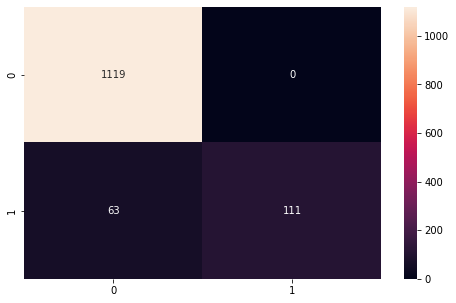

In [144]:
cf_matrix=metrics.confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,5))
sns.heatmap(cf_matrix, annot=True, fmt='d')

#### Logistic Regression

In [145]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_class = logreg.predict(X_test)
metrics.accuracy_score(y_test, y_pred_class)

0.9412219644238206

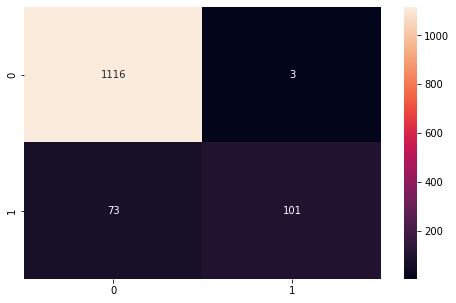

In [146]:
lr_matrix=metrics.confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,5))
sns.heatmap(lr_matrix, annot=True, fmt='d')

MultinomialNB가 더 높은 성능을 보임